# Walkthrough
This notebook follows an example trackpy project from start to finish. We take video of micron-sized particles diffusing in water, track them, and analyze the trajectories to obtain the viscosity of water.

At the bottom of the notebook, we very briefly survey the more advanced features of trackpy. Browse the rest of the [documentation](https://soft-matter.github.io/trackpy/stable) to learn more.

# Scientific IPython Setup
We need Python's plotting library, matplotlib. Your environment might load matplotlib automatically, but for this tutorial I'll load it explicitly using this convention. If you are unfamiliar with matplotlib, do the same as I do here, and everything that follows will work without modification.

In [4]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline
#%matplotlib notebook  

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')


We also might want to use scientific Python libraries. Finally, we'll import trackpy itself and its sister project, pims.

In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

# Variable Set Up

In [6]:
fps = 50
pixel_per_micron = 10.72
file_dir = '/Volumes/AndersonLab/Hausen W/Data/2022_07_08_1um_nyo_beads_14dex/for tracking/dex_4_MMStack_Pos0.ome.tif'
work_dir = '/'.join(file_dir.split('/')[:-1]) + '/'

alpha = .94568

print(work_dir)

/Volumes/AndersonLab/Hausen W/Data/2022_07_08_1um_nyo_beads_14dex/for tracking/


We use the alias tp for brevity.

# Step 1: Read the Data
## Opening images or video
To get our data into Python, we use our sister project, PIMS (Python Image Sequence). [PIMS](https://github.com/soft-matter/pims) makes it easy and convenient to load and process video data from many formats with one consistent interface.

Using PIMS, trackpy can read:
- a directory or zipfile of sequential images
- a multi-frame TIFF file
- a video (AVI, MOV, etc.)
- specialty formats used in microscopy and scientific video capture:
  -   Cine, NorPix seq
  - LSM
  - Files supported by [Bioformats](https://www.openmicroscopy.org/site/support/bio-formats5.1/supported-formats.html)
  - ND2 using [PIMS_ND2](https://github.com/soft-matter/pims_nd2)
(Some of the formats require some extra dependencies. For a complete list, see the README page for PIMS, or the installation instructions in the documentation.)

For many formats, using <mark>pims.open</mark> just works. Since these images are in color, we also need to set up a pipeline to convert each image to grayscale when it is read.

### For TIFF

In [7]:
#frames = gray(pims.open('../sample_data/bulk_water/*.png'))
frames = pims.open(file_dir)
#frames = pims.open("2-K16-L_Lipid14-5-1_dex40-T.nd2")

In [8]:
frames

<Frames>
Source: /Volumes/AndersonLab/Hausen W/Data/2022_07_08_1um_nyo_beads_14dex/for tracking/dex_4_MMStack_Pos0.ome.tif
Length: 3000 frames
Frame Shape: (83, 81)
Pixel Datatype: uint8

In [9]:
# find the number of frames
#You can use Image.n_frames to find the number of frames in a TIFF. It was added in Pillow 2.9.0.
from PIL import Image
img = Image.open(file_dir)
n_frame1 = img.n_frames
print(n_frame1)

# second method to find the number of frames 
#imarray = np.array(frames)
#a1=imarray.shape[0]
#n_frame1 = int(a1)
#print(n_frame1)

3000


We can access any frame like <mark>frames[frame_number]</mark>. The image is represented as a numpy array of intensities. If you're using the [Anaconda distribution](https://www.anaconda.com/distribution/) of Python, these should be in the range [0, 255]. If you have a more custom environment they may be in the range [0, 1], in which case you'll have to experiment with the <mark>minmass</mark> parameters below.

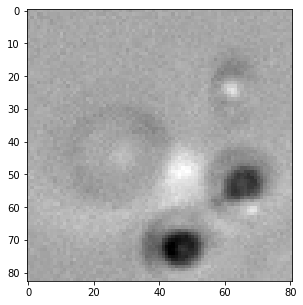

In [10]:
plt.imshow(frames[0]);

# Step 2: Locate Features
Start with just the first frame. Estimate the size of the features (in pixels). The size must be an odd integer, and it is better to err on the large side, as we'll see below. We estimate 11 pixels.

In [11]:
inv = True

In [12]:
f = tp.locate(frames[0], 11, invert=inv)

The algorithm looks for bright features; since the features in this set of images are dark, we set invert=True.

locate returns a spreadsheet-like object called a DataFrame. It lists

- each feature's position,
- various characterizations of its appearance, which we will use to filter out spurious features,
- the "signal" strength and an estimate of uncertainty, both derived from this paper

More information about DataFrames may be found in the pandas documentation. DataFrames can easily be exported to formats like CSV, Excel, SQL, HDF5, etc.

In [13]:
len(f.x)  # give the number of the features = size of x in f

12

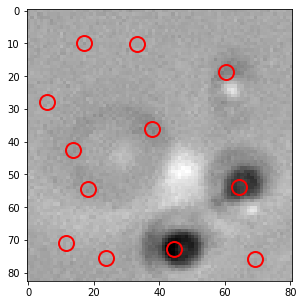

<AxesSubplot:>

In [14]:
tp.annotate(f, frames[0])

# Refine parameters to elminate spurious features
Many of these circles are clearly wrong; they are fleeting peaks in brightness that aren't actually particles. Rejecting them often improves results and speeds up feature-finding. There are many ways to distinguish real particles from spurious ones. The most important way is to look at total brightness ("mass").

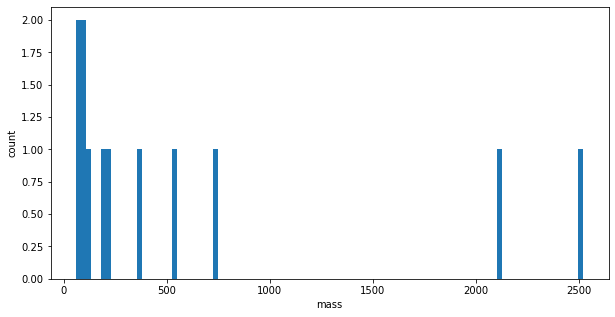

In [15]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

We can then specify the minmass parameter. If your image is especially noisy, you may also find the threshold parameter useful.

### Set Parameters

In [16]:
par_d = 15
min_mass = 2500
test_f = 0

In [17]:
f = tp.locate(frames[test_f], par_d, invert=inv, minmass=min_mass)

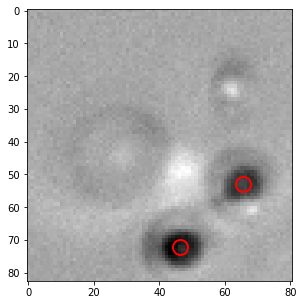

<AxesSubplot:>

In [18]:
tp.annotate(f, frames[test_f])

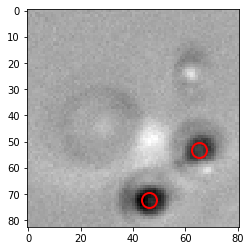

Text(3.200000000000017, 0.5, 'y')

In [19]:
 # use "%matplotlib notebook " to be able change figue and save it
%matplotlib inline   
ax  = tp.annotate(f, frames[test_f])
#len(f.x)  # give the number of the fitures = size of x in f

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("x", fontweight ='bold' , fontsize = 14)
ax.set_ylabel('y', fontweight ='bold', fontsize = 14)

#plt.savefig("circled_molecules.png", dpi=300)
# plt.savefig(work_dir + "circled_molecules.jpg")
#plt.savefig("circled_molecules.svg")

In [20]:
%matplotlib inline 
#%matplotlib notebook 

In [21]:
#tp.annotate?

There are more options for controling and optimizing feature-finding. You can review them in the [documentation](https://soft-matter.github.io/trackpy/stable/), where the most comprehensive description is in the API reference. Or, pull them up as you work by typing <mark>tp.locate?</mark> into IPython.

# Check for subpixel accuracy
As Eric Weeks points out in his related tutorial, a quick way to check for subpixel accuracy is to check that the decimal part of the x and/or y positions are evenly distributed. Trackpy provides a convenience plotting function for this called <mark>subpx_bias</mark>:

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

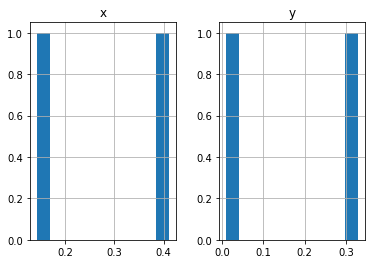

In [22]:
tp.subpx_bias(f)

If we use a mask size that is too small, the histogram often shows a dip in the middle.

In [23]:
# tp.subpx_bias(tp.locate(frames[0], 5, invert=False, minmass=20));

# Locate features in all frames
Or, to start, just explore a subset of the frames.


  ## selection	                | syntax example
 
 all the frames:  ---           	frames[:] or simply frames.<br/>
 the first 10 frames:---       	frames[:10] <br/>
 the last 10 frames: ---        	frames[-10:] <br/>
 a range of frames: ---         	frames[100:200] <br/>
 every 10th frame:	 ---       frame[::10] <br/>
 a list of specific frames:---	frames[[100, 107, 113]] <br/>

We'll locate features in the first 300 frames from this video. We use tp.batch, which calls tp.locate on each frame and collects the results.

In [24]:
#tp.quiet(suppress=True) # turn off printing the frame number and the features number to speed up the code
tp.quiet(suppress=False) # Turn on progress reports
f = tp.batch(frames[:2000], par_d, minmass=min_mass, invert=inv, processes=1);

Frame 599: 2 features


As each frame is analyzed, tp.batch reports the frame number and how many features were found. If this number runs unexpectedly low or high, you may wish to interrupt it and try different parameters.

If your images are small, you may find that printing this number actually slows down batch significantly! In that case you can run tp.quiet() to turn it off.

# Step 3: Link features into particle trajectories
We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement (in pixels), the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its "mass" slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. Here we use 3 frames.

In [25]:
tp.quiet() # Turn off progress reports for best performance (same as tp.quiet(suppress=True))
#tp.quiet(suppress=False) # Turn on progress reports
t = tp.link_df(f, 7, memory=10)

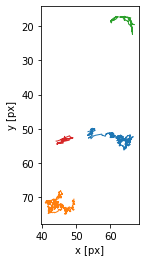

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [26]:
plt.figure()
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1) #sets the height to width ratio. 
tp.plot_traj(t)


# Filter spurious trajectories
We have more filtering to do. Ephemeral trajectories — seen only for a few frames — are usually spurious and never useful. The convenience function filter_stubs keeps only trajectories that last for a given number of frames.

In [27]:
t1 = tp.filter_stubs(t, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 4
After: 4


We can also filter trajectories by their particles' appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

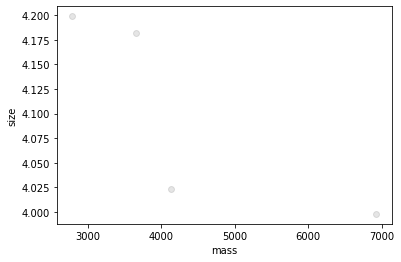

In [28]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

### Filtering

The particles with especially low mass, or that are especially large or non-circular (eccentric), are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using tp.annotate. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

In [29]:
t2 = t1[((t1['mass'] > 0) & (t1['size'] < 20) &
         (t1['ecc'] < .6))]

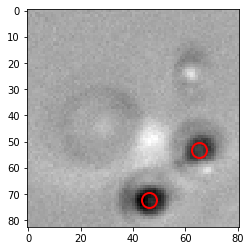

In [30]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);

Trace the trajectories using plot_traj():

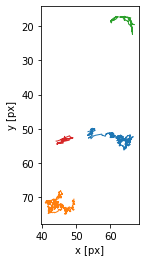

In [31]:
plt.figure()
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1) #sets the height to width ratio. 
tp.plot_traj(t2);

### Eccentricity

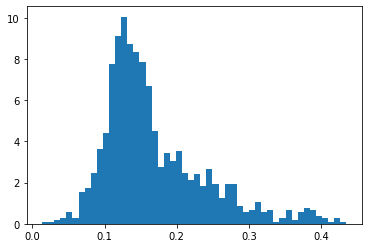

In [32]:
plt.hist(t2.ecc, bins=50,density ='True');
#plt.hist(t2.ecc, bins=50,histtype ="step");

# Step 4: Analyze trajectories
Trackpy includes several functions to help with some common analyses for particle trajectories. (See the "Static Analysis" and "Motion Analysis" sections of the API reference.)

Here, we can show that these data are consistent with colloidal particles undergoing Brownian motion in water.

# Mean Squared Displacement of Individal Probes
Compute the mean squared displacement (MSD) of each particle using the imsd function, and plot MSD vs. lag time.

In [33]:
#im = tp.imsd(t, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24
im = tp.imsd(t2, 1/pixel_per_micron, fps)  # microns per pixel = 100/285., frames per second = 24

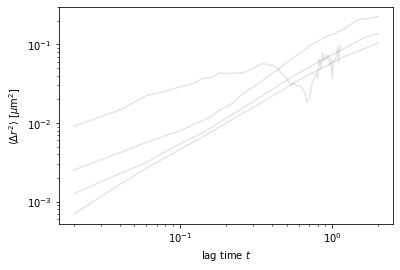

In [34]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

# Ensemble Mean Squared Displacement
Now use the emsd function to compute the ensemble mean squared displacement (EMSD) of all particles:

### Creating Bootstrapping Set

In [35]:
rand = np.random.choice(t2['particle'].unique(), 16)
print(rand)
t3 = pd.DataFrame(columns=t2.columns)
# print(t3)
alr_seen = []
for i in rand:
    df_t = t2[t2['particle'] == i]
    # print(df_t)
    if i not in alr_seen:
        t3 = pd.concat([t3, df_t])
        alr_seen.append(i)
    else:
        k = np.random.randint(1000, 3939)
        while k in alr_seen:
            k = np.random.randint(1000, 3939)
        df_t = df_t.assign(particle = k)
        t3 = pd.concat([t3, df_t])
        alr_seen.append(k)
    # t3.append(df_t)
t3.sort_values(by='frame', ascending=True)
print(t3['particle'].unique())
    

[2 0 3 3 1 0 3 1 3 0 0 0 3 3 0 2]
[2 0 3 2512 1 1078 3913 2584 3664 2634 2617 2352 2727 2091 3131 3360]


In [36]:
#em = tp.emsd(t, 100/285., 24) # microns per pixel = 100/285., frames per second = 24
em = tp.emsd(t3, 1/pixel_per_micron, fps) # microns per pixel = 100/285., frames per second = 24

/Users/hausenwu/.virtualenvs/cv/lib/python3.9/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/Users/hausenwu/.virtualenvs/cv/lib/python3.9/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


## fitting to nonlinear MSD

In [37]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [38]:
def func(x, a, b, c):
    return a*x**b + c

def func2(x, a, b):
    return a*x**b 

def func3(x, a, c):
    return a*x**alpha + c

In [39]:
lim1 = 5
lim2 = 100

In [40]:
x = em.index[lim1:lim2]
y = em.values[lim1:lim2]

In [41]:
popt, pcov = curve_fit(func, x, y)
popt

array([ 0.08094187,  0.84503596, -0.00886206])

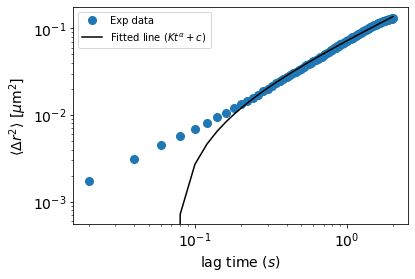

D_eff = 0.02024 μm²/s^α
α = 0.84504 
c = -0.00886 μm²


: 

In [42]:
plt.plot(em.index, em.values, 'o', label='Exp data', markersize=8)
x2=em.index
#plt.plot(x2, m*x2 + c, 'r', label='Fitted line')
plt.loglog(x2, popt[0]*x2**popt[1] + popt[2], 'k', label='Fitted line ($K t^α +c$)')
#ax = em.plot(style='or', label='Trackpy')

plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',fontsize=14)
plt.xlabel('lag time $(s)$', fontsize=14);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

print(r'D_eff = {0:.5f} μm²/s^α'.format(popt[0]/4))
print(r'α = {0:.5f} '.format(popt[1]))
print(r'c = {0:.5f} μm²'.format(popt[2]))